# Salary Analysis from BLS OEWS (2021–2024)

In this exercise, we will examine trends in average annual wages across several accounting and finance-related roles using the Bureau of Labor Statistics Occupational Employment and Wage Statistics (OEWS) data. We will load, tidy, and classify job categories based on occupation codes and titles, and then create summary tables and visualizations to illustrate changes over time.

The purpose is to demonstrate how to prepare multi-year datasets, create derived job groups, and visualize salary trends.



## Import packages


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")


## Load and clean OEWS datasets

Next, we define a helper function to load each OEWS Excel file, remove duplicate rows, ensure column names are tidy, convert wage columns to numeric format, and drop rows missing key identifiers such as occupation codes or titles.


In [2]:
def load_and_clean(path):
    df = pd.read_excel(path)

    # strip spaces from column names
    df.columns = df.columns.str.strip()

    # drop exact duplicates
    df = df.drop_duplicates()

    # drop rows missing key identifiers
    if {"OCC_CODE", "OCC_TITLE"}.issubset(df.columns):
        df = df.dropna(subset=["OCC_CODE", "OCC_TITLE"])

    # ensure wage variables are numeric
    for col in ["A_MEAN", "A_MEDIAN"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    return df


## Load and clean each annual file

Below, we import the files for 2021 through 2024 and append a year indicator to each dataset.


In [3]:
import pandas as pd
df_national_M2024_dl = pd.read_excel('/Users/juliakelly/Library/Application Support/JetBrains/DataSpell2025.2/extensions/Ac 547- project 2/national_M2024_dl.xlsx', index_col=0)
df_national_M2024_dl.columns = df_national_M2024_dl.iloc[0]
df_national_M2024_dl = df_national_M2024_dl[1:]
df_national_M2024_dl

99,U.S.,1,US,0,Cross-industry,cross-industry,1235,00-0000,All Occupations,total,...,23.8,37.89,60.44,29990,36730,49500,78810,125720,NaN,NaN
AREA,,,,,,,,,,,,,,,,,,,,,
99,U.S.,1,US,0,Cross-industry,cross-industry,1235,11-0000,Management Occupations,major,...,58.7,82.5,#,57010,79900,122090,171610,#,NaN,NaN
99,U.S.,1,US,0,Cross-industry,cross-industry,1235,11-1000,Top Executives,minor,...,50.48,81.01,#,47510,68800,104990,168490,#,NaN,NaN
99,U.S.,1,US,0,Cross-industry,cross-industry,1235,11-1010,Chief Executives,broad,...,99.24,#,#,73710,126080,206420,#,#,NaN,NaN
99,U.S.,1,US,0,Cross-industry,cross-industry,1235,11-1011,Chief Executives,detailed,...,99.24,#,#,73710,126080,206420,#,#,NaN,NaN
99,U.S.,1,US,0,Cross-industry,cross-industry,1235,11-1020,General and Operations Managers,broad,...,49.5,78.91,#,47420,67160,102950,164130,#,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,U.S.,1,US,0,Cross-industry,cross-industry,1235,53-7081,Refuse and Recyclable Material Collectors,detailed,...,23.24,29.33,36.16,31810,38330,48350,61010,75200,NaN,NaN
99,U.S.,1,US,0,Cross-industry,cross-industry,1235,53-7120,"Tank Car, Truck, and Ship Loaders",broad,...,27.92,34.25,42.36,38260,47260,58070,71230,88120,NaN,NaN
99,U.S.,1,US,0,Cross-industry,cross-industry,1235,53-7121,"Tank Car, Truck, and Ship Loaders",detailed,...,27.92,34.25,42.36,38260,47260,58070,71230,88120,NaN,NaN


In [4]:
df_2021 = load_and_clean("/Users/juliakelly/Library/Application Support/JetBrains/DataSpell2025.2/extensions/Ac 547- project 2/national_M2024_dl.xlsx")
df_2022 = load_and_clean("/Users/juliakelly/Library/Application Support/JetBrains/DataSpell2025.2/extensions/Ac 547- project 2/national_M2022_dl.xlsx")
df_2023 = load_and_clean("/Users/juliakelly/Library/Application Support/JetBrains/DataSpell2025.2/extensions/Ac 547- project 2/national_M2023_dl.xlsx")
df_2024 = load_and_clean("/Users/juliakelly/Library/Application Support/JetBrains/DataSpell2025.2/extensions/Ac 547- project 2/national_M2024_dl.xlsx")

df_2021["year"] = 2021
df_2022["year"] = 2022
df_2023["year"] = 2023
df_2024["year"] = 2024


## Combine the annual datasets

We now concatenate the files into a single tidy dataset and remove duplicates across years.


In [5]:
df_all = pd.concat([df_2021, df_2022, df_2023, df_2024], ignore_index=True)
df_all = df_all.drop_duplicates()


## Classify occupations into accounting, finance, and business-related groups
Using occupation titles and OCC_CODE prefixes, we create indicator variables for several job groupings:
- **Accountants**
- **Auditors**
- **Tax Professionals**
- **Finance roles**
- **Other Business roles** (using SOC major group 13-****)

We then retain only rows that have been successfully assigned to a job group.
python
Copy code



In [6]:
titles = df_all["OCC_TITLE"]

# Auditors
auditor_mask = titles.str.contains("Auditor|Auditing", case=False, na=False)

# Tax specialists
tax_mask = titles.str.contains("Tax Examiner|Tax Preparer|Tax Collector|Tax Specialist",
                               case=False, na=False)

# Accountants (not auditors or tax)
accountant_mask = (
    titles.str.contains("Accountant|Accounting", case=False, na=False)
    & ~auditor_mask & ~tax_mask
)

# Finance roles
finance_mask = titles.str.contains("Financial|Credit|Budget|Loan Officer",
                                   case=False, na=False)

# Business + financial operations (SOC 13-****)
business_mask = df_all["OCC_CODE"].str.startswith("13")

# assign job group
df_all["Job_Group"] = None
df_all.loc[business_mask, "Job_Group"] = "Other Business"
df_all.loc[finance_mask, "Job_Group"] = "Finance"
df_all.loc[accountant_mask, "Job_Group"] = "Accountants"
df_all.loc[auditor_mask, "Job_Group"] = "Auditors"
df_all.loc[tax_mask, "Job_Group"] = "Tax Professionals"

df_groups = df_all.dropna(subset=["Job_Group", "A_MEAN"])


## Build salary trend table

Below, we compute the average annual wage for each job group by year and reshape the data into a wide format suitable for plotting.


In [7]:
salary_trend = (
    df_groups.groupby(["year", "Job_Group"])["A_MEAN"]
    .mean()
    .reset_index()
)

pivot = salary_trend.pivot(index="year", columns="Job_Group", values="A_MEAN")
pivot


Job_Group,Auditors,Finance,Other Business,Tax Professionals
year,,,,
2021,72770.0,98129.259259,88558.611111,62986.666667
2022,67090.0,90433.703704,80221.111111,59783.333333
2023,70180.0,94957.407407,84185.000000,61476.666667
2024,72770.0,98129.259259,88558.611111,62986.666667


## Plot: Average salary by job group across years

To visualize the trend in wages, we create a grouped bar chart where each cluster represents a year and each bar represents a job category.


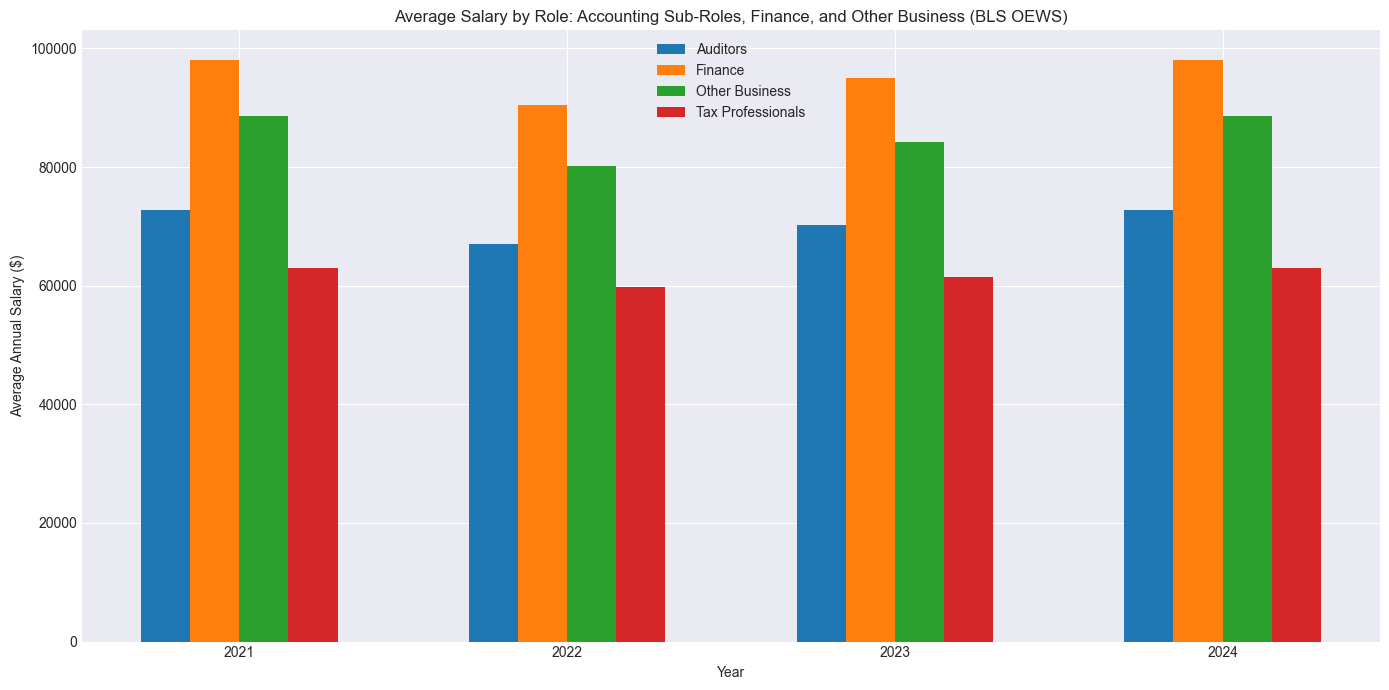

In [8]:
years = pivot.index.to_list()
groups = pivot.columns.to_list()

bar_width = 0.15
x = np.arange(len(years))

plt.figure(figsize=(14, 7))

for i, group in enumerate(groups):
    plt.bar(x + i * bar_width, pivot[group], width=bar_width, label=group)

plt.xticks(x + bar_width * (len(groups) - 1) / 2, years)
plt.xlabel("Year")
plt.ylabel("Average Annual Salary ($)")
plt.title("Average Salary by Role: Accounting Sub-Roles, Finance, and Other Business (BLS OEWS)")
plt.legend()
plt.tight_layout()
plt.show()


# Salary Summary for 2024

Now, let’s focus on the most recent OEWS release (2024). Below, we filter the dataset to 2024 only and compute the mean salary for each job category.


In [9]:
df_2024_only = df_groups[df_groups["year"] == 2024]

avg_2024 = (
    df_2024_only.groupby("Job_Group")["A_MEAN"]
    .mean()
    .sort_values()
)
avg_2024


Job_Group
Tax Professionals    62986.666667
Auditors             72770.000000
Other Business       88558.611111
Finance              98129.259259
Name: A_MEAN, dtype: float64

## Plot: Average salary by job group (2024)

The bar chart below illustrates the relative salary levels across occupational categories for 2024.


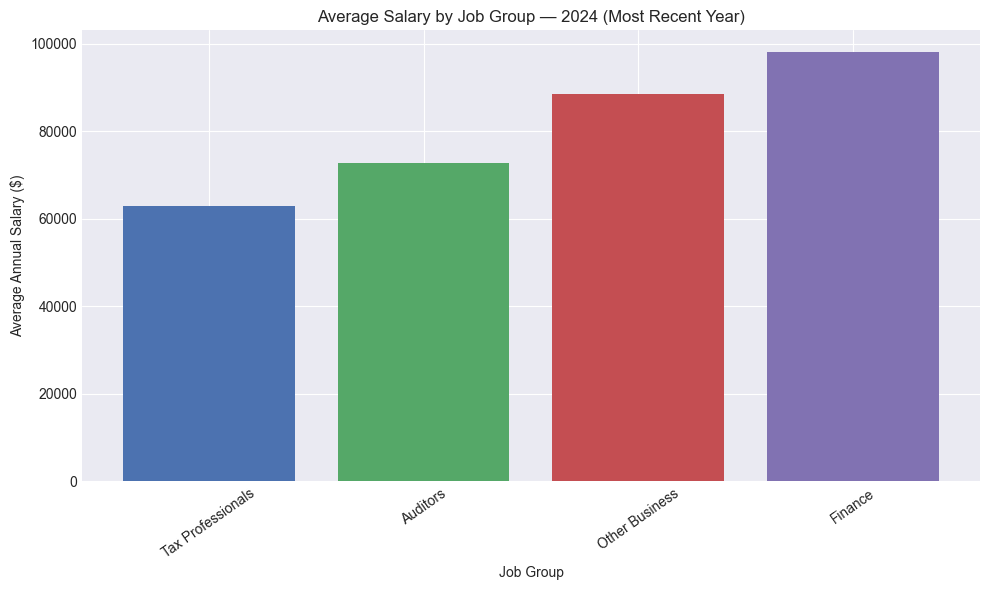

In [10]:
plt.figure(figsize=(10, 6))
plt.bar(
    avg_2024.index,
    avg_2024.values,
    color=["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#CCB974"]
)

plt.xlabel("Job Group")
plt.ylabel("Average Annual Salary ($)")
plt.title("Average Salary by Job Group — 2024 (Most Recent Year)")
plt.xticks(rotation=35)
plt.tight_layout()
plt.show()
